# Self-Driving Car Engineer Nanodegree

## Deep Learning Project: Build a Traffic Sign Recognition Classifier

In this project a deep neural network classifier for the German Traffic Sign Recognition Benchmark (GTSRB) will be developed. 
The network architecture will be bases on the classical LeNet.



## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'traffic-signs-data/train.p'
validation_file='traffic-signs-data/valid.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
#X_train, y_train = train['features'], train['labels']
#X_valid, y_valid = valid['features'], valid['labels']
#X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


### Basic Summary of the Data Set 

In [32]:
import numpy as np

# Number of training examples
n_train = train['features'].shape[0]

n_valid = valid['features'].shape[0]

# Number of testing examples.
n_test = test['features'].shape[0]

#  What's the shape of an traffic sign image?
image_shape = (test['features'].shape[1], test['features'].shape[2])

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(test['labels'])) 

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


### Exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

(-0.5, 31.5, 31.5, -0.5)

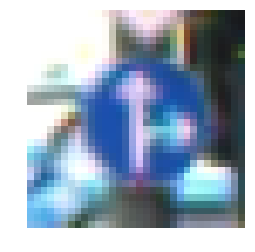

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline

class_num = 36
class_indices = np.argwhere(train['labels'] == class_num)[:,0]

plt.imshow(train['features'][class_indices[120]])
plt.axis('off')

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set

To improve the performance of the neural network, some preprocessing is applied to the traffic sign images.

The grayscale function merges color channels according to the YUV color space definition:

In [4]:
def grayscale(rgb):
    
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b    

    return gray

The normalize function maps pixel intensity values to the interval [-1, 1]:

In [5]:
def normalize(img):    
    
    max_val = np.max(img)
    min_val = np.min(img)
    
    return (img - min_val)*2.0/(max_val - min_val) - 1.0

Gray scaling and normalization is applied to the whole set of training, validation and test data:

In [6]:
def preprocessImages(images):
    n_images = images.shape[0]
    
    X = np.zeros((n_images, 32, 32, 1))
    
    for i in range(n_images):
        img = normalize(grayscale(images[i]))
        img.shape = (32, 32, 1)
        X[i] = img
    
    return X

y_train      = train['labels']
y_validation = valid['labels']
y_test       = test['labels']

X_train      = preprocessImages(train['features'])
X_validation = preprocessImages(valid['features'])
X_test       = preprocessImages(test['features'])

### Duplicate examples of rare classes 

In order to improve classification for rare classes (classes that don't have many examples) the training examples of these rare classes get duplicated:

In [7]:
n, indices, counts = np.unique(train['labels'], return_index=True, return_counts=True)

med = np.median(counts)

X_train_fake = np.copy(X_train)
y_train_fake = np.copy(y_train)

for i in range(n_classes):
    class_label = train['labels'][indices[i]]
    num_examples = counts[i]   
   
    #print('class {} has {} elements'.format(class_label, num_examples))    
    
    # if the number of examples is small, duplicate all examples of this class 
    if num_examples < med:
        
        X_train_fake = np.append(X_train_fake, X_train[y_train == class_label], axis=0)
        y_train_fake = np.append(y_train_fake, y_train[y_train == class_label], axis=0)


X_train = X_train_fake    
y_train = y_train_fake 

n_train = y_train.shape[0]

### Model Architecture

To capture more detail from the training data the LeNet architecture gets extended. 
The convolution layers are now deeper and dropout has been added to the fully connected layers.

In [8]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle

def ExtendedLeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # changed 28x28x6 to 28x28x8
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x8.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 8), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(8))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x8. Output = 14x14x8.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # changed 10x10x16 to 10x10x20
    # Layer 2: Convolutional. Output = 10x10x20.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 8, 20), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(20))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x20. Output = 5x5x20.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x20. Output = 500.
    fc0   = flatten(conv2)

    # Layer 3: Fully Connected. Input = 500. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(500, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b

    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b

    # Activation.
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2, keep_prob) # added dropout
    
    # ----------------------------------------
    # added another fully connected layer 
    
    # Layer 5: Fully Connected. Input = 84. Output = 60.
    fc21_W  = tf.Variable(tf.truncated_normal(shape=(84, 60), mean = mu, stddev = sigma))
    fc21_b  = tf.Variable(tf.zeros(60))
    fc21    = tf.matmul(fc2, fc21_W) + fc21_b

    # Activation.
    fc21    = tf.nn.relu(fc21)
    fc21    = tf.nn.dropout(fc21, keep_prob) # added dropout
    
    #------------------------------------------

    # Layer 6: Fully Connected. Input = 84. Output = n_classes.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(60, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc21, fc3_W) + fc3_b

    return logits, conv1, conv2




### Train, Validate and Test the Model

A validation set is used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [9]:

rate = 0.001

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)
keep_prob = tf.placeholder(tf.float32)

logits, conv1, conv2 = ExtendedLeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Training

In [10]:
EPOCHS = 20
BATCH_SIZE = 128

perform_training = False

if perform_training:

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train)

        print("Training...")
        print()
        for i in range(EPOCHS):
            X_train, y_train = shuffle(X_train, y_train)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})

            validation_accuracy = evaluate(X_validation, y_validation)
            print("EPOCH {} ...".format(i+1))
            print("Validation Accuracy = {:.3f}".format(validation_accuracy))
            print()

        saver.save(sess, './lenet')
        print("Model saved")

## Test on Test Data Set 
 

In [11]:
with tf.Session() as sess:

    saver.restore(sess, './lenet')
    #sess.run(tf.global_variables_initializer())

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.932


## Step 3: Test Model on New Images

In this section the model is used to predict the sign type of new images from the web. The images have been cropped to a quadratic shape containing the traffic sign.

### Load and Output the Images

The following figure shows the new test images from the web. Images in the top row are displayed in their native resolution while images in the bottom row have been downsampled to 32x32 (input size of the network).

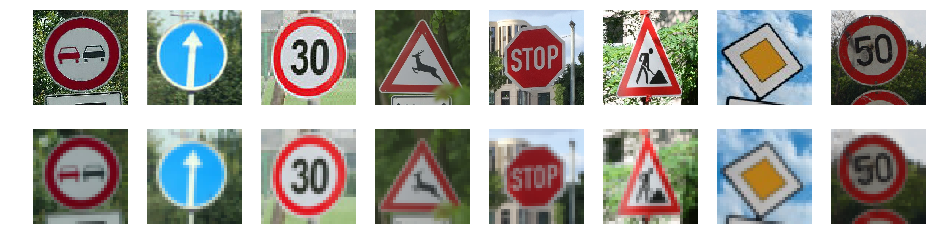

In [12]:
import matplotlib.image as mpimg
from scipy.misc import imresize

num_images = 8

images = []
images_hr = []

for n in range(num_images):
    img_hr = mpimg.imread('./traffic_signs/{}.jpg'.format(n+1))
    images_hr.append(img_hr)
    images.append(imresize(img_hr, (32,32)))

plt.figure(figsize = (16, 4))

for i in range(num_images):
    plt.subplot(2,num_images,i+1)
    plt.imshow(images_hr[i])
    plt.axis('off')
    
    plt.subplot(2,num_images,num_images+i+1)
    plt.imshow(images[i])
    plt.axis('off')


In [13]:
# manually set the right classes for each image
class_labels = [9, 35, 1, 31, 14, 25, 12, 2]

### Predict the Sign Type for Each Image

In [14]:
images_processed = []

for i in range(num_images):
    images_processed.append(normalize(grayscale(images[i])))
    


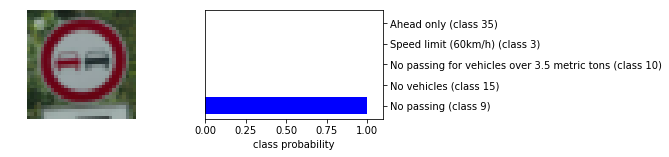

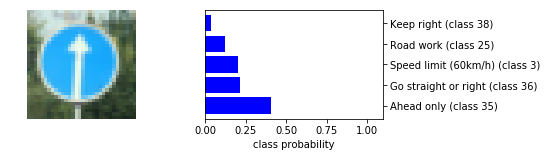

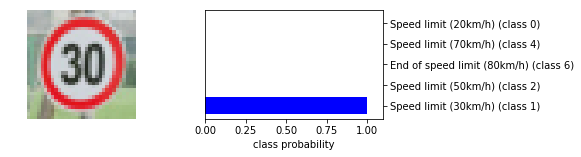

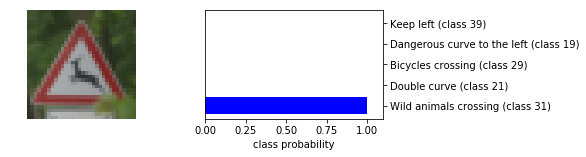

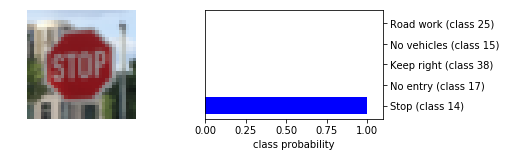

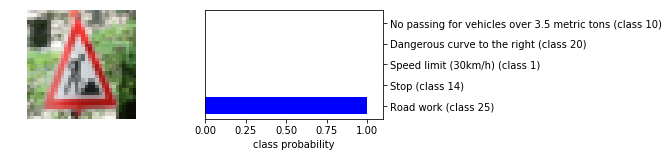

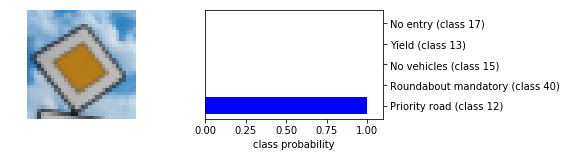

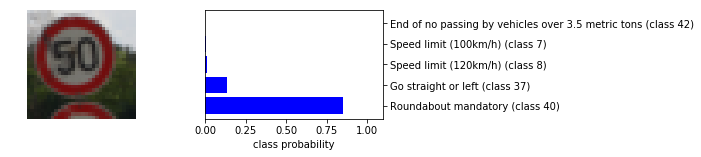

In [15]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x))


def visualizePrediction(img, orig_img, sess):
    img.shape = (1,32,32,1)

    result = sess.run(logits,feed_dict={x: img, keep_prob: 1.0})
    result.shape = (result.shape[1]) 

    probs = softmax(result)

    probs_sort_indices = np.argsort(probs)[::-1]
    top_classes = probs_sort_indices[0:5]

    class_labels_predicted[i] = top_classes[0] #best prediction


    plt.figure(figsize = (7, 2))    
    
    plt.subplot(1,2,1)
    plt.imshow(orig_img)       
    plt.axis('off')            

    plt.subplot(1,2,2)
    plt.barh(range(5), probs[top_classes], color="blue")
    labels = []
    for c in top_classes:  
        labels.append('{} (class {})'.format(class_dict[str(c)], c))                                    

    plt.yticks(range(5), labels)
    #plt.ylabel('class')
    plt.xlabel('class probability')
    plt.xlim([0, 1.1]) 
    plt.gca().yaxis.tick_right()



import csv

# read the names of the classes into a dictionary
with open('./signnames.csv', mode='r') as infile:
    reader = csv.reader(infile)
    class_dict = {rows[0]:rows[1] for rows in reader}
    

class_labels_predicted = np.zeros(num_images)

with tf.Session() as sess:
    saver.restore(sess, './lenet')
    
    for i in range(8):
        img = images_processed[i]
        
        visualizePrediction(img, images[i], sess)
        
               

### Performance Analysis

In [16]:
accuracy = 1.0 - len(np.nonzero(class_labels - class_labels_predicted))/num_images

print("Accuracy on test images = {:.3f}".format(accuracy))

Accuracy on test images = 0.875


The model managed to predict the correct class labels for 7 out of the 8 images from the web. 

For the one wrong prediction (last image) the right class is not even in the top 5 predictions. This might have to do with the fact that the traffic sign is slightly at an angle. Let's try it again when we manually correct the orientation of the image:

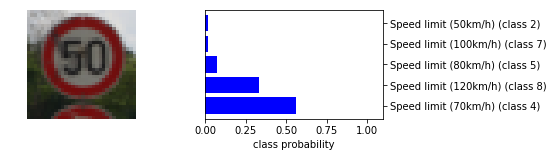

In [28]:
img_hr = mpimg.imread('./traffic_signs/8_rot.jpg')
image = imresize(img_hr, (32,32))

image_processed = normalize(grayscale(image))
  
visualizePrediction(image_processed, image, sess)
        


Even though the correct label (class 2) is now inside the top 5 predictions (5th place), it is still far from the most probable prediction. Other factors (e.g. the dirt in the traffic sign) seem to still fool the network into thinking the image shows a "70" instead of a "50".

---

## Step 4: Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

In [18]:
# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

sess = tf.Session()
saver.restore(sess, './lenet')   

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it maybe having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input, keep_prob : 1.0})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

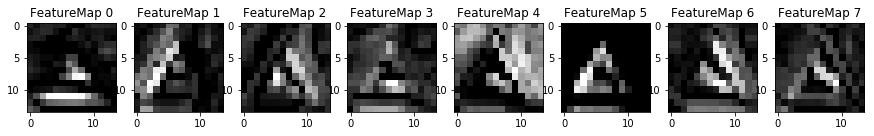

In [31]:
# feed an example image 
outputFeatureMap(images_processed[3], conv1)

### Question 9

Discuss how you used the visual output of your trained network's feature maps to show that it had learned to look for interesting characteristics in traffic sign images


**Answer:**

The plots above show that the network places high avtivations on interesting features of the input image. 
The outline of the triangular shape is especially emphasized in the feature maps 0, 1, 5 and 6. Feature map 7 also clearly shows how the shape of the animal depicted on the traffic sign leads to high activation.


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 